# OBJECTIVE

This python notebook implements a convolutional and a fully connected neural network architecture in Python 0.4 for performing classification on a CIFAR dataset. This may help as a starting reference for some of the common pytorch implementation details, like using Dataloading pipeline, performing optimization, saving best models, etc. 

# Step 0: Loading important modules and framing some helper functions

In [26]:
#importing dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt
import pickle #to store model histories in a file

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

In [27]:
#specifying controllable parameters

NUM_TRAIN = 49000 #number of training examples
device = torch.device('cpu')
print_every = 100 #frequency of printing loss

In [28]:
#saving and loading histories

def save_histories(data, model_type = 'conv'):
    '''
    data to store in the file
    model_type main files are 'fc' or 'conv'
    '''
    filepath = './histories_' + model_type + '.txt'
    with open(filepath, 'wb') as fp:
        pickle.dump(data, fp)
        
def load_histories(filename):
    '''
    Filename: txt file
    '''
    with open(filename, "rb") as fp:
        out = pickle.load(fp)
        
    return out

In [39]:
#plotting function for analysis

def plot_(data, legend = ['1'], title = ' ', xlabel = ' ', ylabel = ' ', save = False, show = False, file_name = None, y_lim = None, epoch = 0):
    '''
    data input will be a list of plot datas to be plot together on the graph
    legend will be a list of legend values
    title, xlabel, and ylabel will be strings
    y_lim will be a tuple (ymin, xmin), none for no limit
    '''
    N = len(data)
    fig = plt.figure()
    
    for i in range(N):
        plt.plot(data[i])
      
    plt.legend(legend)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if y_lim != None:
        plt.ylim((0,100))
        

    if save:
        name = file_name + '_epoch_{:d}'.format(epoch)
        fig.savefig(name, format='eps', dpi=1200)

    if show:
        plt.show()
    else:
        plt.close()
    


In [30]:
#load an image example

def load_CIFAR_batch(filename):
  """ load a single batch of CIFAR. Has 5 training batches of 1000 examples each, and 1 test batch"""
  with open(filename, 'rb') as f:
    datadict = cpickle.load(f, encoding = 'latin1')
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32)
    Y = np.array(Y)
    return X, Y

def image_show(x):
    '''Input x is a numpy array of the form (3, H, W) and needs to be of the form (H,W,3)'''
    x = x.transpose(1,2,0)
    plt.imshow(x.astype('uint8'))
    plt.show()

# Step 1: Framing the data pipeline

In [31]:
#downloading and splitting the CIFAR-10 Dataset

#transforming based on mean and std for CIFAR data across its 3 channels
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                    ])

#splitting the dataset in train(49000), val(1000), and test
#sampler object helps sampling for the test-dev split
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


**Data Specs**
Each example is a (N, 3, 32, 32)

# Sept 2: Defining class for a convolutional network model 

In [32]:
#defining the model based on convolutional network

class model_conv(nn.Module):
    '''
    Defines the model used in this classification task
    
    Inputs to define the model:
    conv1_out, conv2_out, conv3_out, hd_fc1, hd_fc2, classes
    
    Used Classes:
    class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
    class torch.nn.ReLU(inplace=False)
    class torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    class torch.nn.Dropout(p=0.5, inplace=False)
    class torch.nn.Linear(in_features, out_features, bias=True)
    '''
    
    def __init__(self, conv1_out, conv2_out, conv3_out, hd_fc1, hd_fc2, classes = 10):
        super(model_conv,self).__init__()
        self.conv1 = nn.Conv2d(3, conv1_out, 5, padding=2, bias = True) #input has 3 channels; padding done in a way that saves spatial dim
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, 3, padding=1, bias = True)
        self.conv3 = nn.Conv2d(conv2_out, conv3_out, 3, padding = 1, bias = True)
        
        self.fc1 = nn.Linear(conv3_out*32*32, hd_fc1, bias=True)
        self.fc2 = nn.Linear(hd_fc1, hd_fc2, bias=True)
        self.fc3 = nn.Linear(hd_fc2, classes, bias=True)
        
        self.batch2d1 = nn.BatchNorm2d(conv1_out) #2d batchnorm for conv1
        self.batch2d2 = nn.BatchNorm2d(conv2_out)
        self.batch2d3 = nn.BatchNorm2d(conv3_out)
        
        self.batch1d1 = nn.BatchNorm1d(hd_fc1) #id batchnorm for layers
        self.batch1d2 = nn.BatchNorm1d(hd_fc2)
        
        
        self.relu = nn.ReLU()
        self.drop0_5 = nn.Dropout(p=0.5)
        self.drop0_2 = nn.Dropout(p=0.2)
        
    def forward(self, x):
        '''
        Computes forward of the function
        '''
        a1 = self.relu(self.batch2d1(self.conv1(x)))
        a1 = self.drop0_5(a1)
        
        a2 = self.relu(self.batch2d2(self.conv2(a1)))
        a2 = self.drop0_5(a2)
        
        a3 = self.relu(self.batch2d3(self.conv3(a2)))
        a3 = self.drop0_5(a3)
        
        a3 = a3.view(a3.shape[0], -1) #flattening the input to feed in fully connected layers
        
        a4 = self.relu(self.batch1d1(self.fc1(a3)))
        a4 = self.drop0_2(a4)
        
        a5 = self.relu(self.batch1d2(self.fc2(a4)))
        
        out = self.fc3(a5) 
        
        return out

# Step 2: Defining the fc model

In [33]:
class Flatten(nn.Module):
    def forward(self, x):
        N = x.shape[0] 
        return x.view(N, -1)

#a 3 hidden layer fully connected network
hd1, hd2, hd3 = [1000, 500, 200]
learning_rate = 1e-2

model_fc = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hd1),
    nn.BatchNorm1d(hd1),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(hd1, hd2),
    nn.BatchNorm1d(hd2),
    nn.ReLU(),
    nn.Dropout(0.1),
    
    nn.Linear(hd2, hd3),
    nn.BatchNorm1d(hd3),
    nn.ReLU(),
    
    nn.Linear(hd3, 10) #cifar has 10 classes, so this gives us score
  
    )

# Step 3: Defining training and testing functions

In [34]:
#training mode
def train(model, loader, optim, epochs = 1, modeltype = 'conv', resume = False, print_every = print_every):
    '''
    modeltype tells if the training is for the conv model or for the fc model to save as different training files
    '''
    best_acc = -1
    best_model = None
    model = model.to(device=device)
    loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    filepath = './training_checkpoints_' + modeltype + '.pt'
    
    #if we are reusing pretrained weights from the best model so far
    if resume:
        model.load_state_dict(torch.load(filepath))
                              
    for ep in range(epochs):
        loss_per_epoch = 0.
        print("Starting {} epoch of training".format(ep+1))
        print("Best accuracy: {:.3f}".format(best_acc))
        
        for t, (x,y) in enumerate(loader):
            model.train()  #set the model in the training mode, that makes a difference with dropout, normalization, etc
            
            x = x.to(device=device)
            y = y.to(device=device)
            
            pred = model(x)
            loss = F.cross_entropy(pred, y)
            loss_per_epoch += loss
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            #printing results as per the specified frequency
            if t % print_every == 0:
                print("Loss this iteration: {:.3f}".format(loss))
        
        #code to check overfitting and save the best model
        train_acc = test(model, loader_train)
        
        val_acc = test(model, loader_val)
        loss_per_epoch /= (t+1)
        
        #saving history
        loss_history.append(loss_per_epoch)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        
        #plotting accuracy curves
        plot_([train_acc_history, val_acc_history], legend = ['Train acc', 'Val acc'], 
              title = 'Accuracies vs Epochs for ' + modeltype, xlabel = 'Epochs', ylabel = 'Accuracy', 
              save = True, show = True, file_name = './accuracies_' + modeltype, y_lim = (0,100), epoch = ep + 1)
        
        #plotting loss curves
        plot_([loss_history], legend = ['Loss'], title = 'Loss vs Epochs for FC' + modeltype,
              xlabel = 'Epochs', ylabel = ' Loss', 
              save = True, show = True, file_name = './loss_' + modeltype, y_lim = None, epoch = ep + 1)

        if val_acc > best_acc:
            best_model = model
            best_acc = val_acc
            torch.save(model.state_dict(), filepath)
            no_improve_count = 0
        else:
            no_improve_count += 1
            
        if no_improve_count >= 5:
            print('No improvement for last {} epochs. You might consider stopping training'.format(no_improve_count))
            
            
    return (loss_history,  train_acc_history, val_acc_history)

In [35]:
#evaluation mode
def test(model, loader):
    model = model.to(device=device)
    model.eval()
    
    loss_val = 0.
    num_correct = 0.
    num_samples = 0.
    
    with torch.no_grad():
        for x,y in loader: 

            #compatible for gpu use
            x = x.to(device=device)
            y = y.to(device=device)

            pred = model(x)
            loss = F.cross_entropy(pred, y)
            loss_val += loss

            #checking accuracy
            _, score = pred.max(1)
            num_correct += (score == y).sum()
            num_samples += pred.size(0)

        acc = (float(num_correct)/num_samples)*100.0

    return acc


In [36]:
#predicting from a saved model for a single/random/custom image for random testing
def predict_test(model, data):
    '''Data is a tensor of ((?, 3, 32, 32), y)'''
    model = model.to(device = device)
    model.eval()
    out = False
    
    with torch.no_grad():
        x,y = data
        pred = model(x)
        _, result = pred.max(1)
        if (result == y):
            out = True
            
    return (out, result) 

# Step 4: Training the models

## Training the fc architecture

In [37]:
#defining optim. Model is already defined in place

optim_fc = optim.Adam(model_fc.parameters(), lr = 1e-2) 

Starting 1 epoch of training
Best accuracy: -1.000
Loss this iteration: 0.986
Loss this iteration: 1.051
Loss this iteration: 1.159
Loss this iteration: 1.138


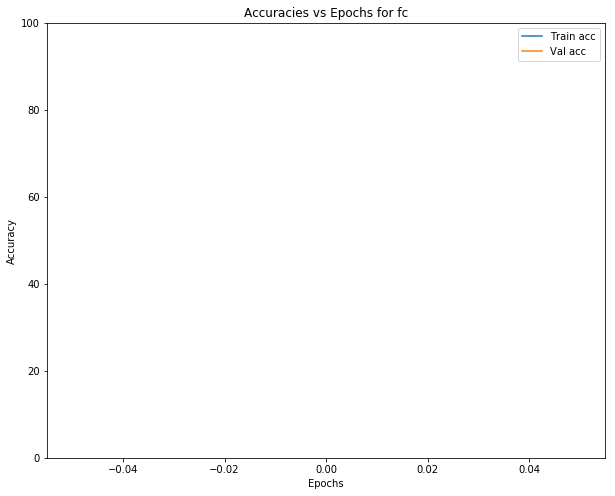

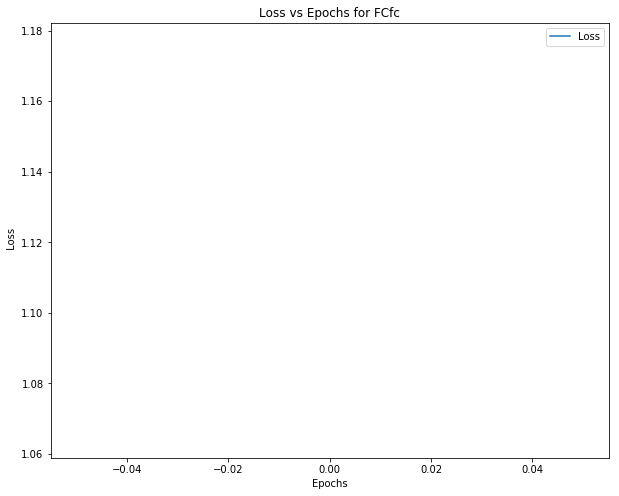

Starting 2 epoch of training
Best accuracy: 57.000
Loss this iteration: 1.130
Loss this iteration: 1.094
Loss this iteration: 1.569
Loss this iteration: 1.093


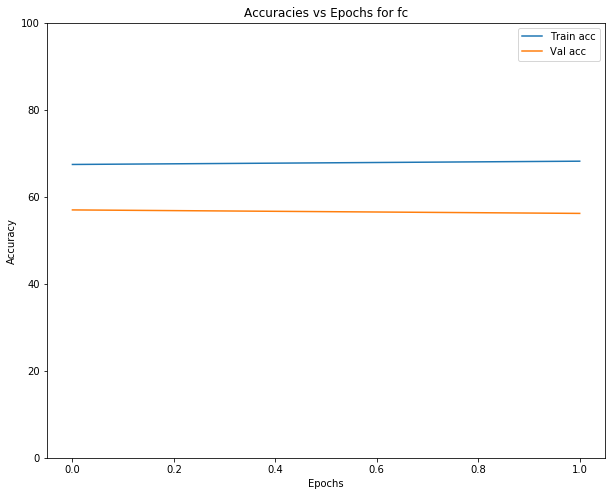

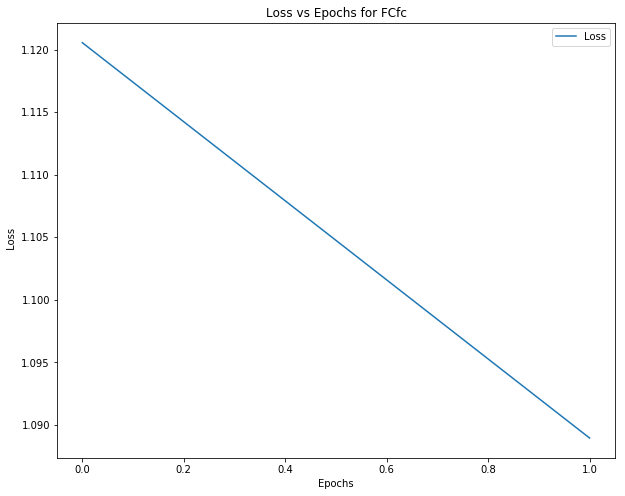

Starting 3 epoch of training
Best accuracy: 57.000
Loss this iteration: 1.160
Loss this iteration: 0.835
Loss this iteration: 0.830
Loss this iteration: 0.903


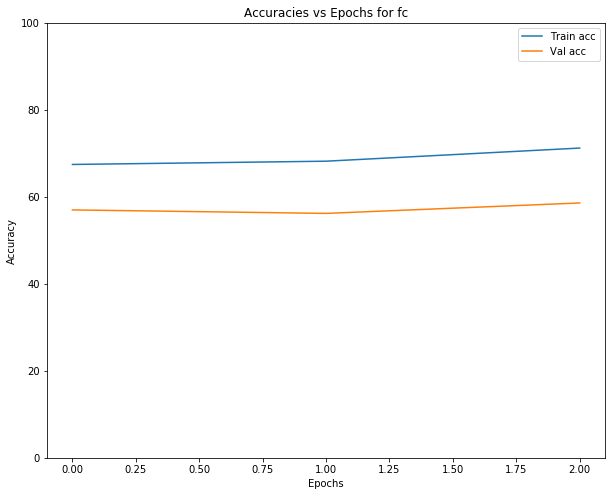

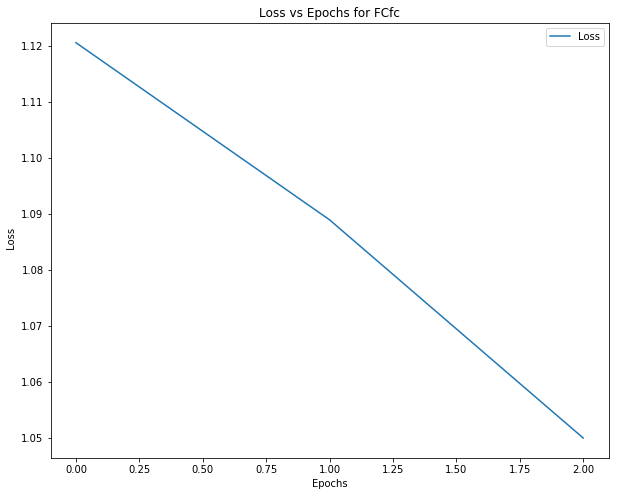

Starting 4 epoch of training
Best accuracy: 58.600
Loss this iteration: 0.866
Loss this iteration: 0.864
Loss this iteration: 1.204
Loss this iteration: 0.799


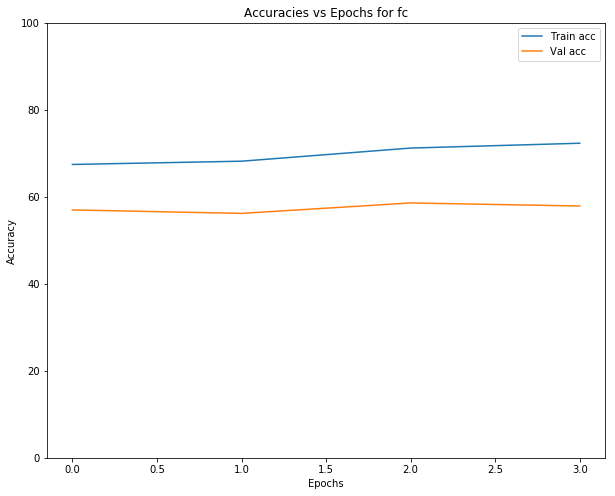

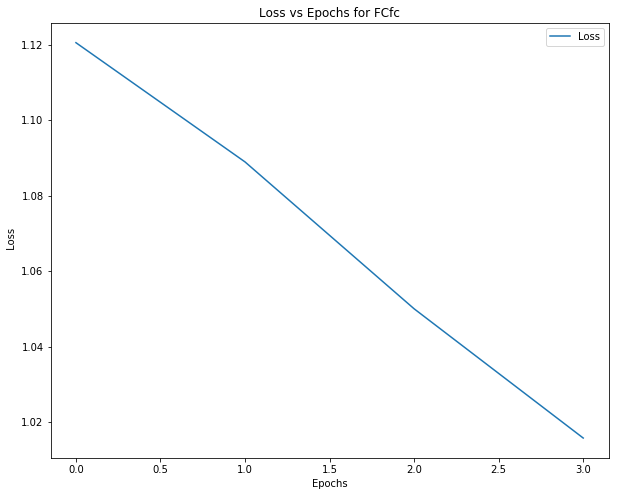

Starting 5 epoch of training
Best accuracy: 58.600
Loss this iteration: 0.869
Loss this iteration: 1.001
Loss this iteration: 0.872
Loss this iteration: 0.840


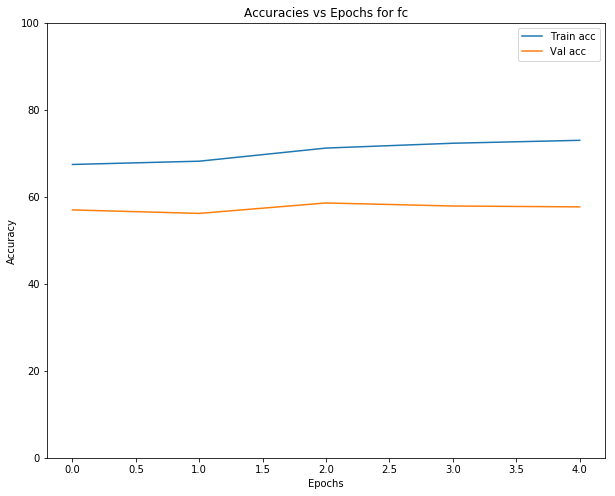

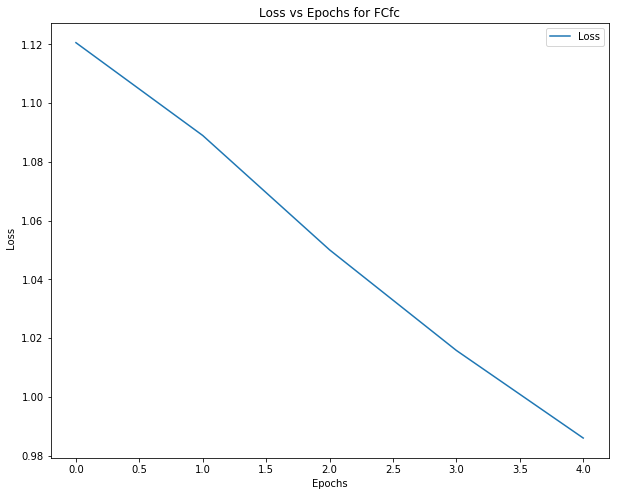

In [40]:
loss_history_fc,  train_acc_history_fc, val_acc_history_fc = \
train(model_fc, loader_train, optim_fc, epochs = 5, modeltype = 'fc', resume = True, print_every = 200) 

#save the histories in a file
data = list((loss_history_fc, train_acc_history_fc, val_acc_history_fc))
save_histories(data, model_type = 'fc') #will be saved in './histories' + model_type + '.txt'

## Training the conv architecture

In [42]:
#defining model and optims.

#used config 
conv1_out, conv2_out, conv3_out, hd_fc1, hd_fc2, classes = (32, 64, 128, 400, 200, 10)
lr = 1e-2

conv_model = model_conv(conv1_out, conv2_out, conv3_out, hd_fc1, hd_fc2, classes)
optim_conv = optim.Adam(conv_model.parameters(), lr = lr) 

Starting 1 epoch of training
Best accuracy: -1.000
Loss this iteration: 0.616
Loss this iteration: 0.738
Loss this iteration: 0.560
Loss this iteration: 0.593


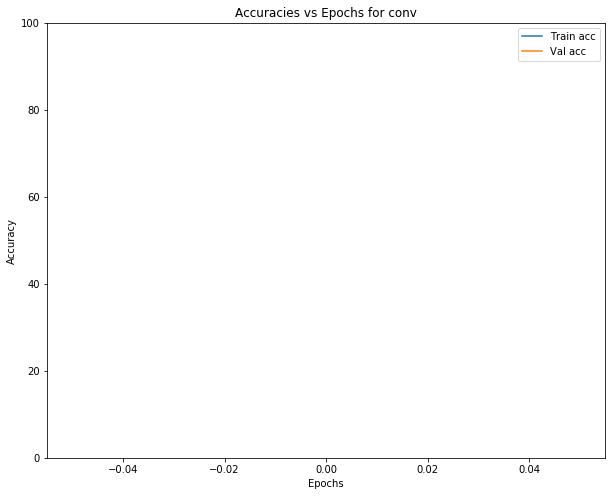

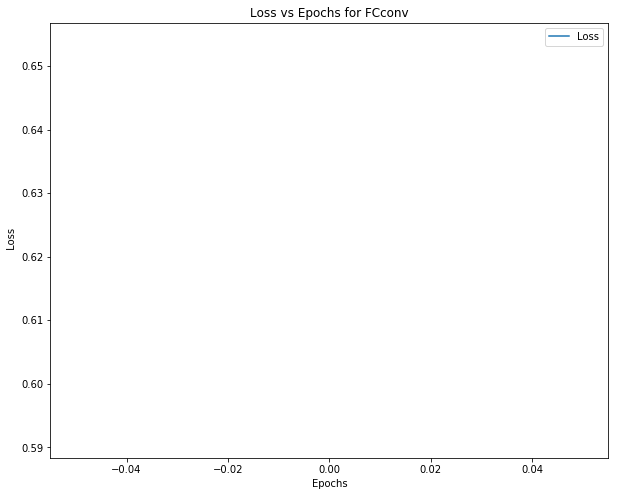

Starting 2 epoch of training
Best accuracy: 74.200
Loss this iteration: 0.512
Loss this iteration: 0.392
Loss this iteration: 0.510
Loss this iteration: 0.494


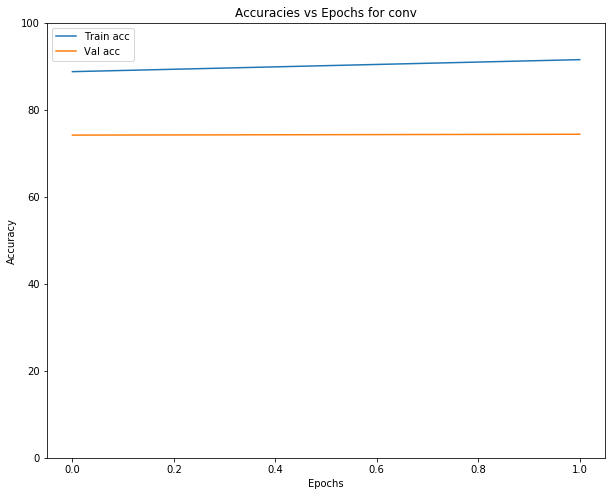

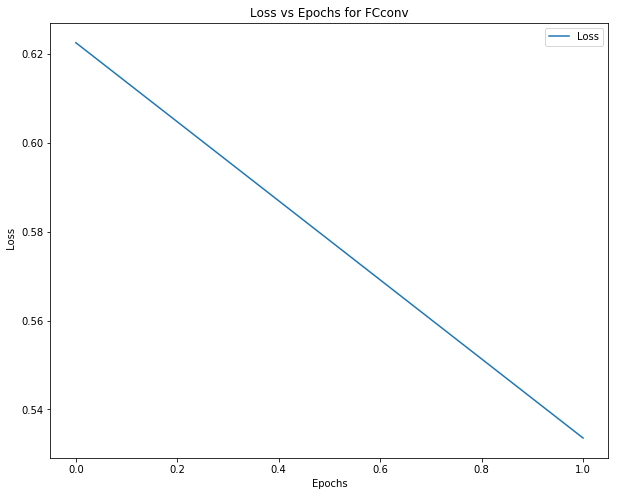

Starting 3 epoch of training
Best accuracy: 74.400
Loss this iteration: 0.385
Loss this iteration: 0.401
Loss this iteration: 0.461
Loss this iteration: 0.725


In [ ]:
#training

loss_history_conv,  train_acc_history_conv, val_acc_history_conv = \
train(conv_model, loader_train, optim_conv, epochs = 5, modeltype = 'conv', resume = True, print_every = 200)

#save the histories in a file
data = list((loss_history_conv, train_acc_history_conv, val_acc_history_conv))
save_histories(data, model_type = 'conv') #will be saved in './histories' + model_type + '.txt'

# Step5: Analyzing results 

This notebook though does not specifically show the hyperparameter search efforts, the built functions will easily support a robust search strategy

## Checking test accuracies of the models

In [14]:
fc_test_acc = test(model_fc, loader_test)
print(fc_test_acc)

54.13


In [19]:
conv_test_acc = test(conv_model, loader_test)
print(conv_test_acc)

72.58


## Analyzing loss curves, performance, etc

In [15]:
#model loading 

load_fc = True
load_conv = True

if load_fc:
    filepath = './training_checkpoints_' + 'fc' + '.pt'
    model_fc.load_state_dict(torch.load(filepath))
    
if load_conv:
    filepath = './training_checkpoints_' + 'conv' + '.pt'
    conv_model.load_state_dict(torch.load(filepath))

In [20]:
file_fc = './histories_' + 'fc' + '.txt'
file_conv = './histories_' + 'conv' + '.txt'

loss_history_fc, train_acc_history_fc, val_acc_history_fc = load_histories(file_fc)
loss_history_conv, train_acc_history_conv, val_acc_history_conv = load_histories(file_conv)

## Analysis for FC

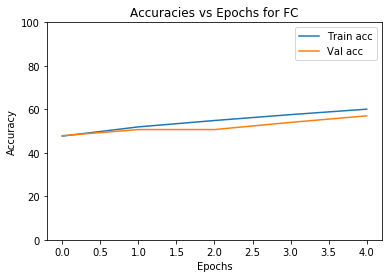

In [23]:
#plotting the training and val accuracies of fc
_ = plot_([train_acc_history_fc, val_acc_history_fc], legend = ['Train acc', 'Val acc'], 
      title = 'Accuracies vs Epochs for FC', xlabel = 'Epochs', ylabel = 'Accuracy', save = True, 
          file_name = './fc_accuracies', y_lim = (0,100))

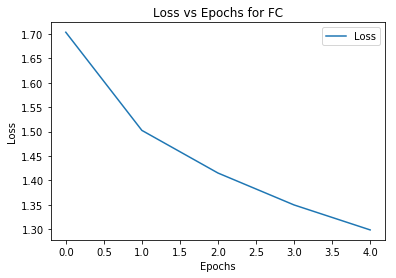

In [24]:
#plotting loss curve
_ = plot_([loss_history_fc], legend = ['Loss'], 
      title = 'Loss vs Epochs for FC', xlabel = 'Epochs', ylabel = 'Loss', save = True, 
          file_name = './fc_loss', y_lim = None)

## Analysis for Conv

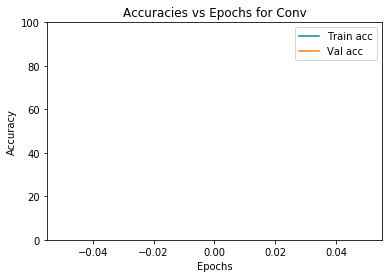

In [25]:
#plotting the training and val accuracies of fc
_ = plot_([train_acc_history_conv, val_acc_history_conv], legend = ['Train acc', 'Val acc'], 
      title = 'Accuracies vs Epochs for Conv', xlabel = 'Epochs', ylabel = 'Accuracy', save = True, 
          file_name = './conv_accuracies', y_lim = (0,100))

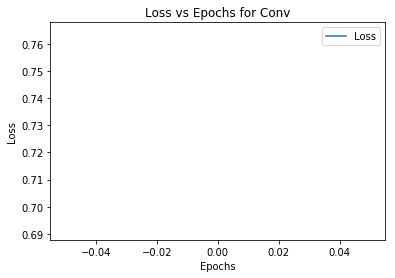

In [26]:
#plotting loss curve
_ = plot_([loss_history_conv], legend = ['Loss'], 
      title = 'Loss vs Epochs for Conv', xlabel = 'Epochs', ylabel = 'Loss', save = True, 
          file_name = './conv_loss', y_lim = None)

torch.float32
Prediction matches: True
Prediction Class: tensor([ 1])  Actual Class: 1


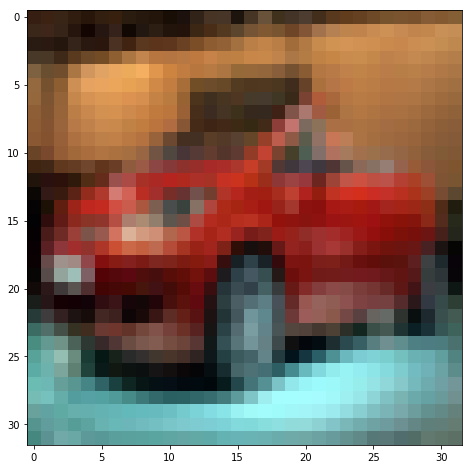

In [64]:
#Plotting one example
example_path = './datasets/cifar-10-batches-py/data_batch_1'
X,Y = load_CIFAR_batch(example_path)
x = torch.from_numpy(X).float()
y = torch.from_numpy(Y)
idx = 45
print(x[idx].dtype)
out, pred  = predict_test(conv_model,(x[idx].view(1,3,32,32),y[idx]))
print("Prediction matches: {}".format(out))
print('Prediction Class: {}  Actual Class: {}'.format(pred, y[idx]))
image_show(X[idx])